Feature extraction :

In [1]:
import pandas as pd
import numpy as np
from scipy import signal as sig
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
source_df = pd.read_csv("data/segments.csv", parse_dates=['timestamp'])
print(f"Number of input rows: {len(source_df)}, and segments: {len(source_df.segment.unique())}")

Number of input rows: 303493, and segments: 2123


In [3]:
def number_of_peaks_finding(array):
    prominence = 0.1 * (np.max(array)-np.min(array))
    peaks = sig.find_peaks(array, prominence=prominence)[0]
    return len(peaks)


def duration(df):
    t1 = pd.Timestamp(df.head(1).timestamp.values[0])
    t2 = pd.Timestamp(df.tail(1).timestamp.values[0])
    return (t2 - t1).seconds


def smooth10_n_peaks(array):
    kernel = np.ones(10)/10
    array_convolved = np.convolve(array, kernel, mode="same")
    return number_of_peaks_finding(array_convolved)


def smooth20_n_peaks(array):
    kernel = np.ones(20)/20
    array_convolved = np.convolve(array, kernel, mode="same")
    return number_of_peaks_finding(array_convolved)


def diff_peaks(array):
    array_diff = np.diff(array)
    return number_of_peaks_finding(array_diff)


def diff2_peaks(array):
    array_diff = np.diff(array, n=2)
    return number_of_peaks_finding(array_diff)


def diff_var(array):
    array_diff = np.diff(array)
    return np.var(array_diff)


def diff2_var(array):
    array_diff = np.diff(array, n=2)
    return np.var(array_diff)


def gaps_squared(df):
    df = df.copy()
    # df["timestamp"] = pd.to_datetime(df["timestamp"])
    df['timestamp2'] = df['timestamp'].shift(1)
    df = df.reset_index().iloc[1:, :]
    df['time_delta'] = (df.timestamp - df.timestamp2).dt.seconds
    df['time_delta_squared'] = df['time_delta']**2
    return df.time_delta_squared.sum()

In [4]:
transformations = {
    "len" : len,
    "mean" : np.mean,
    "var" : np.var,
    "std" : np.std,
    "kurtosis" : kurtosis,
    "skew" : skew,
    "n_peaks" : number_of_peaks_finding,
    "smooth10_n_peaks": smooth10_n_peaks,
    "smooth20_n_peaks": smooth20_n_peaks,
    "diff_peaks" : diff_peaks,
    "diff2_peaks" : diff2_peaks,
    "diff_var" : diff_var,
    "diff2_var" : diff2_var,
}

In [5]:
def generate_dataset(source_df, target_name):
    dataset = []
    for i in tqdm(source_df.segment.unique()):
        res = []
        tdf = source_df.loc[source_df.segment == i, :]
        if tdf.loc[:, "anomaly"].head(1).values == 1:
            anomaly = 1
        else:
            anomaly = 0

        res.append(i)
        res.append(anomaly)
        res.append(tdf.loc[:, "train"].head(1).values[0])
        res.append(tdf.loc[:, "channel"].head(1).values[0])
        res.append(tdf.loc[:, "sampling"].head(1).values[0])
        res.append(duration(tdf))

        for transformation in transformations.values():
            res.append(transformation(tdf.value.values))
        res.append(gaps_squared(tdf))    
        
        dataset.append(res)

    dataset = pd.DataFrame(data=dataset, columns=\
        ["segment", "anomaly", "train", "channel", "sampling", "duration"]
        +list(transformations)+["gaps_squared"])

    dataset["len_weighted"] = dataset["sampling"] * dataset["len"]
    dataset["var_div_duration"] = dataset["var"] / dataset["duration"]
    dataset["var_div_len"] = dataset["var"] / dataset["len"]
    
    dataset.to_csv("data/"+target_name+".csv", index=None)
    return dataset

In [6]:
dataset = generate_dataset(source_df, "__dataset")

100%|██████████| 2123/2123 [00:05<00:00, 381.47it/s]


In [7]:
dataset.groupby(by=['train', 'anomaly'])['segment'].count()

train  anomaly
0      0           416
       1           113
1      0          1273
       1           321
Name: segment, dtype: int64

Feature Selection : Using the correlation matrix 

In [8]:
dataset.head()

,segment,anomaly,train,channel,sampling,duration,len,mean,var,std,...,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff2_peaks,diff_var,diff2_var,gaps_squared,len_weighted,var_div_duration,var_div_len
0,1,1,1,CADC0872,1,279,280,8.533143e-07,3.494283e-10,0.000019,...,3,2,4,6,1.271176e-10,2.960666e-10,309,280,1.252431e-12,1.247958e-12
1,2,1,1,CADC0872,1,476,477,-3.639396e-06,6.476485e-10,0.000025,...,1,1,5,8,1.489383e-12,3.004752e-12,644,477,1.360606e-12,1.357754e-12
2,3,1,1,CADC0872,1,594,595,1.170788e-05,5.592877e-10,0.000024,...,2,2,2,3,4.112280e-12,1.029918e-11,772,595,9.415618e-13,9.399794e-13
3,4,1,1,CADC0872,1,271,272,8.486808e-07,5.466024e-10,0.000023,...,2,2,3,6,2.475760e-11,6.240985e-11,339,272,2.016983e-12,2.009568e-12
4,5,0,0,CADC0872,1,255,257,1.058485e-05,5.279023e-10,0.000023,...,1,1,78,87,5.547101e-13,7.035422e-13,357,257,2.070205e-12,2.054094e-12


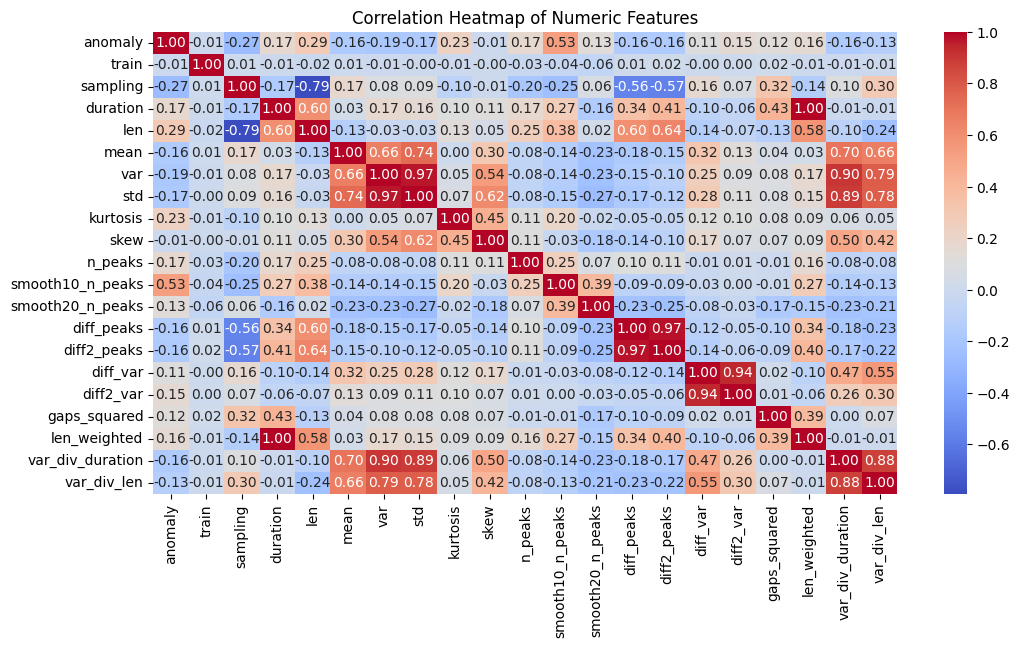

In [9]:
dataset = dataset.drop(columns=['segment', 'channel'], errors='ignore')

numeric_df = dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [10]:
dataset = dataset.drop(columns=['len','sampling', 'std', 'len_weighted', 'diff2_var','diff2_peaks','var_div_len','var_div_duration'], errors='ignore')
dataset.head()

,anomaly,train,duration,mean,var,kurtosis,skew,n_peaks,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff_var,gaps_squared
0,1,1,279,8.533143e-07,3.494283e-10,0.631117,0.552052,4,3,2,4,1.271176e-10,309
1,1,1,476,-3.639396e-06,6.476485e-10,-1.243611,0.425632,1,1,1,5,1.489383e-12,644
2,1,1,594,1.170788e-05,5.592877e-10,-0.284593,-0.826187,3,2,2,2,4.112280e-12,772
3,1,1,271,8.486808e-07,5.466024e-10,-0.887088,-0.138498,2,2,2,3,2.475760e-11,339
4,0,0,255,1.058485e-05,5.279023e-10,-1.484393,-0.060155,1,1,1,78,5.547101e-13,357


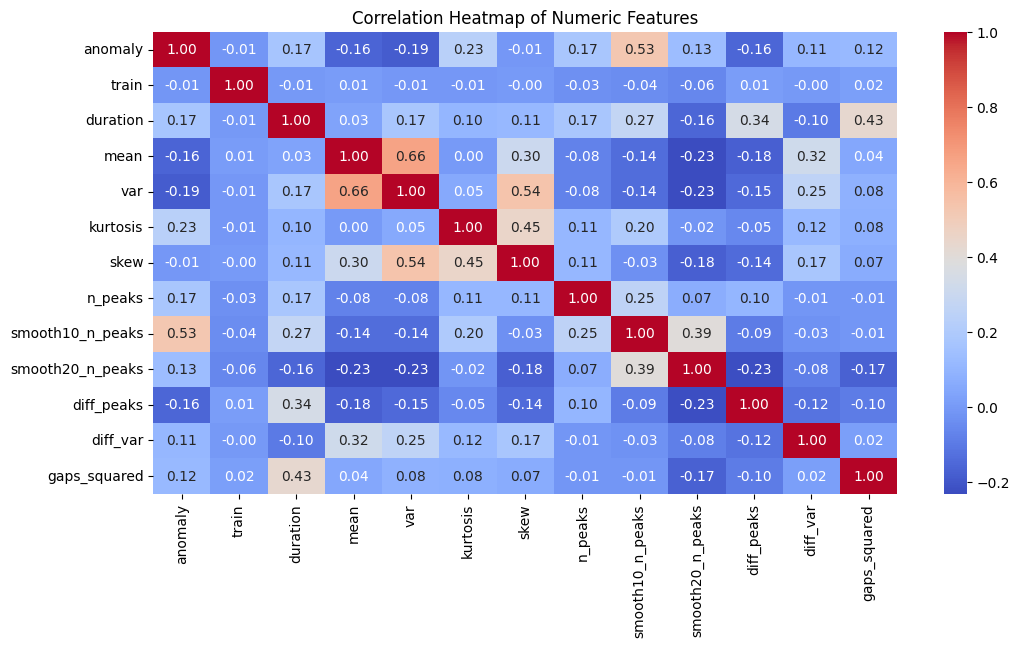

In [11]:
correlation_matrix = dataset.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Saving the final dataset :

In [12]:
dataset.to_csv("data/"+'ready_data'+".csv", index=None)